In [1]:
import io
import os
import platform
import pdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pyplot import cm

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

In [2]:
data=pd.read_csv('montreal2017.csv')
data.replace('InVld',np.nan,inplace=True)
data.replace('<Samp',np.nan,inplace=True)
data.replace('Down',np.nan,inplace=True)
data.replace('Calib',np.nan,inplace=True)
data.replace('NoData',np.nan,inplace=True)
dataset=data.iloc[:,4:].copy()
dataset.to_csv('montreal.csv')
dataset=pd.read_csv('montreal.csv')

In [3]:
dataset=dataset.astype(np.float32)

In [4]:
dataset.iat[0,7]

99.96

99.96

In [5]:
for i in range(len(dataset)):
    for j in range(len(dataset.columns)):
        if np.isnan(dataset.iat[i,j]):
            if i==0:
                dataset.iloc[i,j]=dataset.iat[i+1,j]
            elif i==len(data)-1:
                dataset.iloc[i,j]=dataset.iat[i-1,j]
            else:
                dataset.iloc[i,j]=np.nanmean([dataset.iat[i-1,j],dataset.iat[i+1,j]])

In [6]:
min_value=torch.FloatTensor(dataset.min())
max_value=torch.FloatTensor(dataset.max())

In [7]:
print(min_value)
print(max_value)

tensor([  0.0000, -26.6000, -33.0000,  23.0000,   0.0000,   0.0000,
          0.2000,  97.1700,   0.0000,   0.0000,   0.0000,   6.5000,
          0.0000])
tensor([ 8759.0000,    31.9000,    22.3000,    99.0000,    36.0000,
           67.0000,    80.5000,   103.8800,    72.7000,    77.6000,
           55.9000,   996.9000,    68.6000])
tensor([  0.0000, -26.6000, -33.0000,  23.0000,   0.0000,   0.0000,
          0.2000,  97.1700,   0.0000,   0.0000,   0.0000,   6.5000,
          0.0000])
tensor([ 8759.0000,    31.9000,    22.3000,    99.0000,    36.0000,
           67.0000,    80.5000,   103.8800,    72.7000,    77.6000,
           55.9000,   996.9000,    68.6000])


In [8]:
scaler = preprocessing.MinMaxScaler() 
scaled_values = scaler.fit_transform(dataset) 
# dataset.loc[:,:]=scaled_values

In [9]:
# data_set=np.asarray(dataset,dtype=np.float32)
# seq_len = 30 + 1
# x=len(data_set)-seq_len
# sequences = [data_set[t:t+seq_len] for t in range(x)]
# seq=torch.FloatTensor(sequences)

In [10]:
input_set=np.asarray(scaled_values,dtype=np.float32)
seq_len=30+1
x=len(input_set)-seq_len
sequences=[input_set[t:t+seq_len] for t in range(x)]
for i in range(len(sequences)):
    sequences[i]=scaler.fit_transform(sequences[i])
x_set=torch.FloatTensor(sequences)

In [11]:
x_set.shape

torch.Size([8729, 31, 13])

torch.Size([8729, 31, 13])

In [12]:
split_row=round(0.90*x_set.size(0))
x_train_set=x_set[:split_row, :-1]
y_train_set=x_set[:split_row, -1]
x_valid_set=x_set[split_row:, :-1]
y_valid_set=x_set[split_row:, -1]

In [13]:
y_train_set

tensor([[ 1.0000,  0.4211,  0.5625,  ...,  0.8852,  1.0000,  1.0000],
        [ 1.0000,  0.5132,  0.6719,  ...,  0.9124,  1.0000,  0.7360],
        [ 1.0000,  0.5658,  0.7344,  ...,  1.0000,  0.7536,  0.3614],
        ...,
        [ 1.0000,  0.6444,  1.0000,  ...,  0.1932,  0.0000,  0.0000],
        [ 1.0000,  0.8667,  1.0000,  ...,  0.0874,  0.0000,  0.0000],
        [ 1.0000,  0.9535,  1.0000,  ...,  0.0291,  0.0000,  0.0000]])

tensor([[ 1.0000,  0.4211,  0.5625,  ...,  0.8852,  1.0000,  1.0000],
        [ 1.0000,  0.5132,  0.6719,  ...,  0.9124,  1.0000,  0.7360],
        [ 1.0000,  0.5658,  0.7344,  ...,  1.0000,  0.7536,  0.3614],
        ...,
        [ 1.0000,  0.6444,  1.0000,  ...,  0.1932,  0.0000,  0.0000],
        [ 1.0000,  0.8667,  1.0000,  ...,  0.0874,  0.0000,  0.0000],
        [ 1.0000,  0.9535,  1.0000,  ...,  0.0291,  0.0000,  0.0000]])

In [14]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers=2,dropout=0,bidirectional=False):
        super(LSTM,self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.dropout=dropout
        self.bidirectional=bidirectional
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            dropout=dropout,
                            bidirectional=bidirectional)
        self.linear = nn.Linear(hidden_size, input_size)
        
    def forward(self,inputs,hidden):
        outputs,hidden=self.lstm(inputs,hidden)
        predictions=self.linear(outputs[-1])
        return predictions,outputs,hidden
    
    def init_hidden(self,batch_size):
        num_directions=2 if self.bidirectional else 1
        hidden = (torch.zeros(self.num_layers*num_directions, batch_size, self.hidden_size),
                  torch.zeros(self.num_layers*num_directions, batch_size, self.hidden_size))
        return hidden

In [15]:
def get_batch(x,y,i,batch_size):
    if x.dim() == 2:
        x = x.unsqueeze(2)
    batch_x = x[(i*batch_size):(i*batch_size)+batch_size, :, :]
    batch_y = y[(i*batch_size):(i*batch_size)+batch_size]

    # Reshape Tensors into (seq_len, batch_size, input_size) format for the LSTM.
    batch_x = batch_x.transpose(0, 1)
    
    return batch_x, batch_y

In [16]:
def train(model,x_train_set,y_train_set,optimizer,batch_size,epoch):
    num_sequences=x_train_set.size(0)
    num_batches=num_sequences//batch_size
    
    total_loss=0
    
    model.train()
    for i in range(num_batches):
        # Get input and target batches and reshape for LSTM.
        batch_x, batch_y = get_batch(x_train_set, y_train_set, i, batch_size)

        # Reset the gradient.
        lstm.zero_grad()
        
        # Initialize the hidden states (see the function lstm.init_hidden(batch_size)).
        hidden = lstm.init_hidden(batch_size)
        
        # Complete a forward pass.
        y_pred, outputs, hidden = lstm(batch_x,hidden)
        
        # Calculate the loss with the 'loss_fn'.
        loss = loss_fn(y_pred,batch_y)
        
        # Compute the gradient.
        loss.backward()
        
        # Clip to the gradient to avoid exploding gradient.
        nn.utils.clip_grad_norm_(lstm.parameters(), max_grad_norm)

        # Make one step with optimizer.
        optimizer.step()
        
        # Accumulate the total loss.
        total_loss += loss.data
        
    print("Epoch {}: Loss = {:.8f}".format(epoch+1, total_loss/num_batches))
    return total_loss/num_batches

In [17]:
def eval(model,x_valid_set,y_valid_set,optimizer,batch_size):
    num_sequences=x_valid_set.size(0)
    num_batches=num_sequences//batch_size
    
    total_loss=0
    
    model.eval()
    for i in range(num_batches):
        # Get input and target batches and reshape for LSTM.
        batch_x, batch_y = get_batch(x_valid_set, y_valid_set, i, batch_size)

        # Reset the gradient.
        lstm.zero_grad()
        
        # Initialize the hidden states (see the function lstm.init_hidden(batch_size)).
        hidden = lstm.init_hidden(batch_size)
        
        # Complete a forward pass.
        y_pred, outputs, hidden = lstm(batch_x,hidden)
        
        pred=y_pred*(max_value.sub(min_value))+(min_value)
        
        # Calculate the loss with the 'loss_fn'.
        loss = loss_fn(y_pred,batch_y)
        
        # Compute the gradient.
        loss.backward()
        
        # Clip to the gradient to avoid exploding gradient.
        nn.utils.clip_grad_norm_(lstm.parameters(), max_grad_norm)

        # Make one step with optimizer.
        optimizer.step()
        
        # Accumulate the total loss.
        total_loss += loss.data

    print("Validation: Loss = {:.8f}".format(total_loss/num_batches))
    return total_loss/num_batches

In [18]:
def save_model(epoch, model, path='./'):
    
    # file name and path 
    filename = path + 'montreal.pt'
    
    # load the model parameters 
    torch.save(model.state_dict(), filename)
    
    
    return model

Training model for 30 epoch
Training model for 30 epoch
Epoch 1: Loss = 0.09246875
Epoch 1: Loss = 0.09246875
Validation: Loss = 0.05351315
Validation: Loss = 0.05351315
Epoch 2: Loss = 0.04625485
Epoch 2: Loss = 0.04625485
Validation: Loss = 0.03898960
Validation: Loss = 0.03898960
Epoch 3: Loss = 0.03589375
Epoch 3: Loss = 0.03589375
Validation: Loss = 0.03264852
Validation: Loss = 0.03264852
Epoch 4: Loss = 0.03094397
Epoch 4: Loss = 0.03094397
Validation: Loss = 0.02930296
Validation: Loss = 0.02930296
Epoch 5: Loss = 0.02867482
Epoch 5: Loss = 0.02867482
Validation: Loss = 0.02777198
Validation: Loss = 0.02777198
Epoch 6: Loss = 0.02744476
Epoch 6: Loss = 0.02744476
Validation: Loss = 0.02689401
Validation: Loss = 0.02689401
Epoch 7: Loss = 0.02668482
Epoch 7: Loss = 0.02668482
Validation: Loss = 0.02630113
Validation: Loss = 0.02630113
Epoch 8: Loss = 0.02614713
Epoch 8: Loss = 0.02614713
Validation: Loss = 0.02580957
Validation: Loss = 0.02580957
Epoch 9: Loss = 0.02567809
Epoch

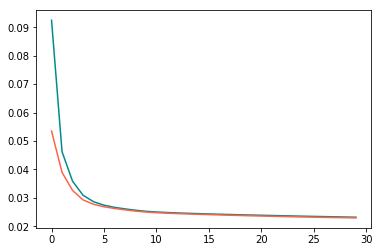

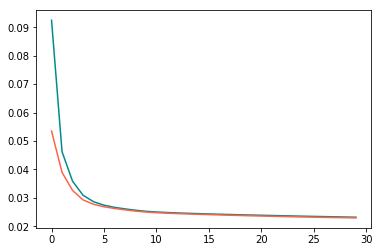

In [19]:
input_size=13
hidden_size=24
num_layers=2
lstm=LSTM(input_size,hidden_size)

learning_rate=0.001
max_grad_norm=5
loss_fn = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=0.00001)

batch_size = 8
num_epochs = 30 #3
# num_sequences = x_train_set.size(0)
# num_batches = num_sequences //batch_size

checkpoint_freq = 10
path = './'

train_losses=[]
valid_losses=[]

print("Training model for {} epoch".format(num_epochs))
for epoch in range(num_epochs):
    total_loss = 0

    # Shuffle input and target sequences.
    idx = torch.randperm(x_train_set.size(0))
    x = x_train_set[idx]
    y = y_train_set[idx]

    train_loss=train(lstm,x_train_set,y_train_set,optimizer,batch_size,epoch)
    valid_loss=eval(lstm,x_valid_set,y_valid_set,optimizer,batch_size)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # Checkpoint
    if epoch % checkpoint_freq ==0:
        save_model(epoch, lstm, path)
        
# Last checkpoint
save_model(num_epochs, lstm, path)
    
print("\n\n\nOptimization ended.\n")

plt.plot(train_losses, color="darkcyan", label="train")
plt.plot(valid_losses, color="tomato",label="validation")
plt.show()

In [20]:
def predict_one_hour(model,x_valid_set,input_size,num_steps):
    predictions=torch.zeros(num_steps)
    for i, x in enumerate(x_valid_set):
        hidden=model.init_hidden(1)
        y_pred,_,_=model(x.contiguous().view(-1, 1, input_size),hidden)
#         predictions[i]=y_pred[:,-1]*(max_value[-1]-min_value[-1])+min_value[-1]
        predictions[i]=y_pred[:,-1]
    return predictions

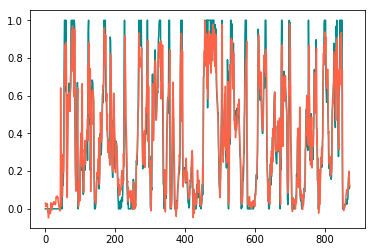

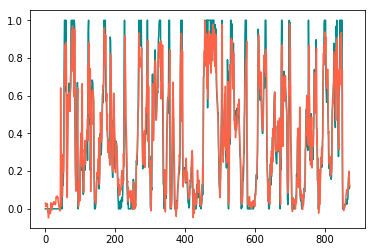

In [21]:
one_step_predictions = predict_one_hour(lstm, x_valid_set, input_size, y_valid_set.size(0))
plt.plot(y_valid_set[:,-1].data.numpy(),color='darkcyan')
plt.plot(one_step_predictions.data.numpy(),color='tomato')
plt.show()